In [14]:
import os
from dotenv import load_dotenv

load_dotenv()
os.environ["GROQ_API_KEY"] = os.getenv("GROQ_API_KEY")
os.environ["TAVILY_API_KEY"] = os.getenv("TAVILY_API_KEY")

create a chatbot with tool capabilities with wiki and arxiv

In [24]:
from langchain_community.tools import WikipediaQueryRun, ArxivQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_groq import ChatGroq




In [25]:
api_wrapper_arxiv = ArxivAPIWrapper(top_k_results=2, document_content_chars_max = 500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv)

api_wrapper=ArxivAPIWrapper(arxiv_search=<class 'arxiv.Search'>, arxiv_exceptions=(<class 'arxiv.ArxivError'>, <class 'arxiv.UnexpectedEmptyPageError'>, <class 'arxiv.HTTPError'>), top_k_results=2, ARXIV_MAX_QUERY_LENGTH=300, continue_on_failure=False, load_max_docs=100, load_all_available_meta=False, doc_content_chars_max=4000)


In [26]:
arxiv.invoke("What are the latest papers on deep learning?")

'Published: 2023-01-03\nTitle: Deep Learning and Computational Physics (Lecture Notes)\nAuthors: Deep Ray, Orazio Pinti, Assad A. Oberai\nSummary: These notes were compiled as lecture notes for a course developed and taught at the University of the Southern California. They should be accessible to a typical engineering graduate student with a strong background in Applied Mathematics.\n  The main objective of these notes is to introduce a student who is familiar with concepts in linear algebra and partial differential equations to select topics in deep learning. These lecture notes exploit the strong connections between deep learning algorithms and the more conventional techniques of computational physics to achieve two goals. First, they use concepts from computational physics to develop an understanding of deep learning algorithms. Not surprisingly, many concepts in deep learning can be connected to similar concepts in computational physics, and one can utilize this connection to bett

In [27]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results= 1, document_content_chars_max = 500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
print(wiki)

api_wrapper=WikipediaAPIWrapper(wiki_client=<module 'wikipedia' from 'c:\\Users\\User\\anaconda3\\envs\\LangGraphv1\\Lib\\site-packages\\wikipedia\\__init__.py'>, top_k_results=1, lang='en', load_all_available_meta=False, doc_content_chars_max=4000)


In [28]:
wiki.invoke("What is LangGraph?")

'Page: WhatsApp\nSummary: WhatsApp Messenger, commonly known simply as WhatsApp, is an American social media, instant messaging (IM), and Voice over IP (VoIP) service accessible via desktop and mobile app. Owned by Meta Platforms, the service allows users to send text messages, voice messages, and video messages, make voice and video calls, and share images, documents, user locations, and other content. The service requires a cellular mobile telephone number to register. WhatsApp was launched in May 2009. In January 2018, WhatsApp released a standalone business app called WhatsApp Business which can communicate with the standard WhatsApp client. As of May 2025, the service had 3 billion monthly active users, making it the most used messenger app. The name of the app is meant to sound like "what\'s up".\nThe service was created by WhatsApp Inc. of Mountain View, California, which was acquired by Facebook in February 2014 for approximately US$19.3 billion. It became the world\'s most pop

In [29]:
tavily = TavilySearchResults()
tavily.invoke("What is the latest news on AI?")


[{'title': 'AI News | Latest News | Insights Powering AI-Driven Business Growth',
  'url': 'https://www.artificialintelligence-news.com/',
  'content': "# Gartner Data & Analytics Summit unveils expanded AI agenda for 2026\n\n#### Applications\n\n### Thailand becomes one of the first in Asia to get the Sora app\n\nEntertainment & Media\n\nOctober 30, 2025\n\n### Malaysia launches Ryt Bank, its first AI-powered bank\n\nFinance AI\n\nAugust 26, 2025\n\n### Google’s Veo 3 AI video creation tools are now widely available\n\nAI in Action\n\nJuly 29, 2025\n\n#### Computer Vision\n\n### US and Japan announce sweeping AI and tech collaboration\n\nArtificial Intelligence\n\nApril 11, 2024\n\n### UK and Canada sign AI compute agreement\n\nArtificial Intelligence\n\nJanuary 31, 2024\n\n### Quantum AI represents a ‘transformative advancement’\n\nAI Hardware & Chips\n\nNovember 14, 2023\n\n#### Machine Learning\n\n### How AI is changing the way we travel\n\nArtificial Intelligence [...] Artificial 

In [30]:
## combining all tolls 

tools = [arxiv, wiki, tavily]

In [33]:
llm = ChatGroq(
    model = "qwen/qwen3-32b")

llm_with_tools = llm.bind_tools(tools)

In [34]:
from langchain_core.messages import AIMessage, HumanMessage
from pprint import pprint

In [36]:
result = llm_with_tools.invoke(
      [HumanMessage(content="What are the latest papers on deep learning, what is LangGraph and what is the latest news on AI?")]
)

result.tool_calls


[{'name': 'arxiv',
  'args': {'query': 'deep learning latest papers'},
  'id': 'vze8j26v5',
  'type': 'tool_call'},
 {'name': 'wikipedia',
  'args': {'query': 'LangGraph'},
  'id': 'sssgfzy6d',
  'type': 'tool_call'},
 {'name': 'tavily_search_results_json',
  'args': {'query': 'latest AI news'},
  'id': 'r833gkcvw',
  'type': 'tool_call'}]

## chatbot with langgraph


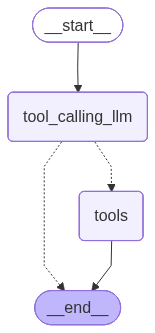

In [38]:
from langgraph.graph import StateGraph, START, END
from IPython.display import display, Image
from langgraph.prebuilt import ToolNode, tools_condition
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

## defining state

class State(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]


## node definition

def tool_calling_llm(state):
    # invoke the LLM bound with tools and return updated messages
    return {"messages": [llm_with_tools.invoke(state["messages"]) ]}


## build graph

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges("tool_calling_llm", tools_condition)
builder.add_edge("tools", END)


graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [40]:
messages = graph.invoke(
    {"messages": [HumanMessage(content="What are the latest papers on deep learning, what is LangGraph and what is the latest news on AI?")]}
)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What are the latest papers on deep learning, what is LangGraph and what is the latest news on AI?
================================== Ai Message ==================================
Tool Calls:
  arxiv (jbtrqhn5v)
 Call ID: jbtrqhn5v
  Args:
    query: deep learning
  wikipedia (kv23a29w8)
 Call ID: kv23a29w8
  Args:
    query: LangGraph
  tavily_search_results_json (p8x5ckn3m)
 Call ID: p8x5ckn3m
  Args:
    query: latest AI news
================================= Tool Message =================================
Name: arxiv

Published: 2023-06-24
Title: Learn to Accumulate Evidence from All Training Samples: Theory and Practice
Authors: Deep Pandey, Qi Yu
Summary: Evidential deep learning, built upon belief theory and subjective logic, offers a principled and computationally efficient way to turn a deterministic neural network uncertainty-aware. The resultant evidential models can quantify fine-grained uncerta

In [41]:
messages = graph.invoke(
    {"messages": [HumanMessage(content="provide recent top 10 news on AI")]}
)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

provide recent top 10 news on AI
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (janwnvyyh)
 Call ID: janwnvyyh
  Args:
    query: recent top 10 AI news
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "Top 10 AI Newsletters to Follow in 2026 - DataNorth AI", "url": "https://datanorth.ai/blog/top-10-ai-newsletters-to-follow-in-2026", "content": "Superhuman AI is particularly valuable for marketers and sales leaders. Recent data suggests that AI tools can help small businesses generate 50% more qualified leads and achieve 20-30% higher conversion rates. Kahn’s curation filters through the daily noise to identify the “superhuman feats”, breakthroughs in model efficiency and reasoning that directly impact career acceleration. The newsletter’s “Sunday Special”

In [42]:
messages = graph.invoke(
    {"messages": [HumanMessage(content="what is machine learning")]}
)

for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

what is machine learning
================================== Ai Message ==================================
Tool Calls:
  wikipedia (nm9bxcgfp)
 Call ID: nm9bxcgfp
  Args:
    query: machine learning
================================= Tool Message =================================
Name: wikipedia

Page: Machine learning
Summary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalize to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.
ML finds application in many fields, including natural language processing, computer vision, speech recognition, email filterin